In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve

In [2]:
#Read datasets
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

#Drop useless features
df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)
df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

#LabelEncode categorical features
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train[i]=le.fit_transform(df_train[i])

for i in c:
    df_test[i]=le.fit_transform(df_test[i])

#Normalize pure numeric features 
scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="emotion" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features
scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test

#Set X_train,y_train = data to fit models. Set X_test,y_test = data to test models.
col=[x for x in df_train.columns if x!="emotion"]
X_train=df_train[col].values
y_train = np.array(df_train["emotion"])
X_test=df_test[col].values
y_test = np.array(df_test["emotion"])

In [3]:
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,...,sc_skew_w4,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,1,5,0,1,0,1,0.018034,0.603864,-0.063106,-0.7693,...,-4.354785,0.161158,-0.925138,2.167997,1.515260,1.079945,0.690192,0.036057,9.400360,-3.035005
1,1,5,0,1,1,1,0.013950,0.603864,-0.063106,-0.7693,...,-0.659640,-0.173413,1.908839,1.610931,0.996435,0.639413,0.409754,0.036057,-0.186504,0.434538
2,1,5,0,0,0,1,0.018855,0.622665,-0.063106,-0.7693,...,-3.086640,-0.286208,-0.925138,1.285119,1.118715,0.877776,0.722854,0.036057,2.891302,-1.463754
3,1,5,0,0,1,1,0.018087,0.603864,-0.063106,-0.7693,...,-0.396009,-0.588962,1.429546,1.176485,0.899140,0.723117,0.560400,0.036057,-0.049566,-0.052845
4,1,1,0,1,0,1,0.015921,0.603864,-0.063106,-0.7693,...,-0.624456,0.170902,0.987370,1.346235,1.065980,0.761301,0.452031,0.036057,0.878701,-0.532241


In [4]:
df_test.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,...,sc_skew_w4,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,1,5,0,1,0,1,0.059131,0.566262,-0.063106,-0.66600,...,0.089520,0.032398,1.432748,1.571823,1.132435,0.998570,0.840181,0.036057,0.380443,-0.407209
1,1,5,0,1,1,1,0.015160,0.547461,-0.063106,-0.66600,...,0.185582,-0.837184,0.387863,0.461505,0.603874,0.543109,0.310605,0.036057,0.163243,-0.454832
2,1,5,0,0,0,1,-0.076467,0.585063,-0.063106,-0.70732,...,0.407398,-0.497760,-0.746120,0.616325,0.724799,0.612342,0.605368,0.036057,1.523245,-1.137587
3,1,5,0,0,1,1,-0.010822,0.566262,-0.063106,-0.68666,...,0.870601,-0.191064,1.904671,1.384208,0.978261,0.895372,0.793457,0.036057,-0.347161,0.014413
4,1,1,0,1,0,1,0.016999,0.585063,-0.063106,-0.68666,...,-1.252102,0.547445,1.372430,1.137679,0.997185,0.867312,0.823776,0.036057,0.024425,-0.362935


# Single Perceptron

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV


In [6]:
#Grid Search

tuned_parameters= {
    'penalty':['l1','l2','elasticnet'],
    'alpha':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tol':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}

k_fold = StratifiedKFold()

pct=Perceptron()
clf=GridSearchCV(pct, tuned_parameters, scoring='f1_macro', error_score='raise', cv=k_fold)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters set found on development set:
{'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.68      0.61        96
           1       0.52      0.68      0.59        96
           2       0.46      0.50      0.48        48
           3       0.67      0.39      0.49        96
           4       0.31      0.39      0.34        96
           5       0.38      0.29      0.33        48
           6       0.42      0.20      0.27        96
           7       0.38      0.58      0.46        48

    accuracy                           0.46       624
   macro avg       0.46      0.46      0.45       624
weighted avg       0.48      0.46      0.45       624



In [7]:
clf=Perceptron(alpha=0.0001, penalty='l1', tol= 0.001)
clf.fit(X_train, y_train)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.68      0.61        96
           1       0.52      0.68      0.59        96
           2       0.46      0.50      0.48        48
           3       0.67      0.39      0.49        96
           4       0.31      0.39      0.34        96
           5       0.38      0.29      0.33        48
           6       0.42      0.20      0.27        96
           7       0.38      0.58      0.46        48

    accuracy                           0.46       624
   macro avg       0.46      0.46      0.45       624
weighted avg       0.48      0.46      0.45       624



# Multilayer Perceptron

In [8]:
from sklearn.neural_network import MLPClassifier

Mlp 1 Hidden Layer

In [9]:
tuned_parameters={
    'hidden_layer_sizes':[(8),(16),(32),(64)],
    'activation':['relu','tanh'],
    'momentum' : list(np.arange(0.1, 1.1, 0.2)),
    'learning_rate': ['constant','adaptive'],
    'alpha':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tol':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}
k_fold = StratifiedKFold()
mlp = MLPClassifier(solver='adam')
clf=GridSearchCV(mlp, tuned_parameters, scoring='f1_macro', cv=k_fold)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer

Best parameters set found on development set:
{'activation': 'tanh', 'alpha': 1.0, 'hidden_layer_sizes': 64, 'learning_rate': 'adaptive', 'momentum': 0.9000000000000001, 'tol': 1e-05}
Classification report:
              precision    recall  f1-score   support

           0       0.53      0.81      0.64        96
           1       0.52      0.66      0.58        96
           2       0.53      0.60      0.56        48
           3       0.61      0.40      0.48        96
           4       0.41      0.42      0.41        96
           5       0.45      0.44      0.44        48
           6       0.48      0.28      0.36        96
           7       0.50      0.42      0.45        48

    accuracy                           0.51       624
   macro avg       0.50      0.50      0.49       624
weighted avg       0.51      0.51      0.49       624



d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification report:
              precision    recall  f1-score   support

           0       0.50      0.79      0.61        96
           1       0.60      0.71      0.65        96
           2       0.49      0.60      0.54        48
           3       0.69      0.40      0.50        96
           4       0.46      0.43      0.44        96
           5       0.48      0.48      0.48        48
           6       0.41      0.25      0.31        96
           7       0.49      0.48      0.48        48

    accuracy                           0.52       624
   macro avg       0.51      0.52      0.50       624
weighted avg       0.52      0.52      0.50       624



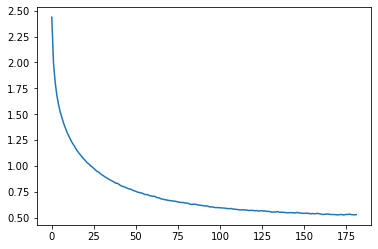

In [66]:
# Best Configuration

clf = MLPClassifier(solver = 'adam', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=[64],activation='tanh',alpha=1.0,tol=0.00001)
clf.fit(X_train, y_train)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))
plt.plot(clf.loss_curve_)
plt.show()

Mlp 2 hidden layer

In [10]:
tuned_parameters={
    'hidden_layer_sizes':[(8,16),(16,32),(32,64)],
    'activation':['relu','tanh'],
    'momentum' : list(np.arange(0.1, 1.1, 0.2)),
    'learning_rate': ['constant','adaptive'],
    'alpha':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tol':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}
k_fold = StratifiedKFold()
mlp = MLPClassifier(solver='adam')
clf=GridSearchCV(mlp, tuned_parameters, scoring='f1_macro', cv=k_fold)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer

Best parameters set found on development set:
{'activation': 'tanh', 'alpha': 1.0, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'adaptive', 'momentum': 0.1, 'tol': 0.0001}
Classification report:
              precision    recall  f1-score   support

           0       0.52      0.79      0.63        96
           1       0.55      0.70      0.61        96
           2       0.50      0.58      0.54        48
           3       0.60      0.40      0.48        96
           4       0.43      0.40      0.41        96
           5       0.49      0.52      0.51        48
           6       0.47      0.26      0.34        96
           7       0.52      0.50      0.51        48

    accuracy                           0.51       624
   macro avg       0.51      0.52      0.50       624
weighted avg       0.51      0.51      0.50       624



d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification report:
              precision    recall  f1-score   support

           0       0.54      0.84      0.66        96
           1       0.55      0.70      0.62        96
           2       0.54      0.62      0.58        48
           3       0.62      0.40      0.48        96
           4       0.40      0.43      0.41        96
           5       0.59      0.48      0.53        48
           6       0.46      0.28      0.35        96
           7       0.58      0.44      0.50        48

    accuracy                           0.53       624
   macro avg       0.54      0.52      0.52       624
weighted avg       0.53      0.53      0.51       624



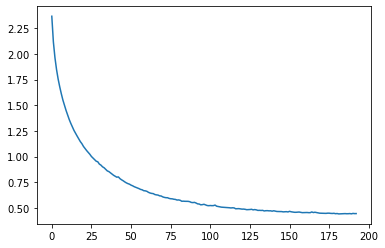

In [64]:
# Best Configuration

clf = MLPClassifier(solver = 'adam', momentum = 0.1, learning_rate = 'adaptive' , hidden_layer_sizes=[32,64],activation='tanh',alpha=1.0,tol=0.0001)
clf.fit(X_train, y_train)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))
plt.plot(clf.loss_curve_)
plt.show()

Mlp 3 hidden layer

In [11]:
tuned_parameters={
    'hidden_layer_sizes':[(32, 16, 8), (64, 32, 16), (128, 64, 32)],
    'activation':['relu','tanh'],
    'momentum' : list(np.arange(0.1, 1.1, 0.2)),
    'learning_rate': ['constant','adaptive'],
    'alpha':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tol':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}
k_fold = StratifiedKFold()
mlp = MLPClassifier(solver='adam')
clf=GridSearchCV(mlp, tuned_parameters, scoring='f1_macro', cv=k_fold)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer

Best parameters set found on development set:
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'momentum': 0.7000000000000001, 'tol': 0.0001}
Classification report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        96
           1       0.49      0.55      0.52        96
           2       0.48      0.54      0.51        48
           3       0.67      0.44      0.53        96
           4       0.42      0.51      0.46        96
           5       0.53      0.38      0.44        48
           6       0.43      0.40      0.41        96
           7       0.39      0.35      0.37        48

    accuracy                           0.49       624
   macro avg       0.49      0.48      0.48       624
weighted avg       0.50      0.49      0.49       624



d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [62]:
# Best Configuration

clf = MLPClassifier(solver = 'adam', momentum = 0.7, learning_rate = 'constant' , hidden_layer_sizes=[128,64,32],activation='tanh',alpha=0.1,tol=0.0001)
clf.fit(X_train, y_train)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.77      0.64        96
           1       0.61      0.66      0.63        96
           2       0.47      0.54      0.50        48
           3       0.59      0.41      0.48        96
           4       0.44      0.46      0.45        96
           5       0.43      0.42      0.43        48
           6       0.39      0.30      0.34        96
           7       0.48      0.42      0.44        48

    accuracy                           0.50       624
   macro avg       0.49      0.50      0.49       624
weighted avg       0.50      0.50      0.50       624



d:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


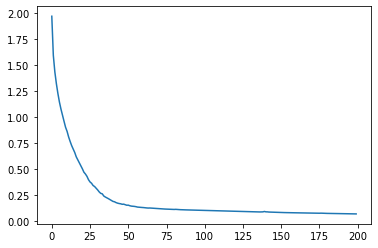

In [63]:
plt.plot(clf.loss_curve_)
plt.show()

In [12]:
# Grid Search

"""

tuned_parameters={
    'hidden_layer_sizes':[(8,),(16,),(32,),(64,),(8,16,),(16,32,),(32,64,),(32, 16, 8,), (64, 32, 16,), (128, 64, 32,)],
    'activation':['relu','tanh'],
    'momentum' : list(np.arange(0.1, 1.1, 0.1)),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'solver': ['adam','sgd'],
    'alpha':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tol':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}
k_fold = StratifiedKFold()

mlp = MLPClassifier()
clf=GridSearchCV(mlp, tuned_parameters, scoring='f1_macro', cv=k_fold)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Classification report:")
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

"""

'\n\ntuned_parameters={\n    \'hidden_layer_sizes\':[(8,),(16,),(32,),(64,),(8,16,),(16,32,),(32,64,),(32, 16, 8,), (64, 32, 16,), (128, 64, 32,)],\n    \'activation\':[\'relu\',\'tanh\'],\n    \'momentum\' : list(np.arange(0.1, 1.1, 0.1)),\n    \'learning_rate\': [\'constant\', \'invscaling\', \'adaptive\'],\n    \'solver\': [\'adam\',\'sgd\'],\n    \'alpha\':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],\n    \'tol\':[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],\n}\nk_fold = StratifiedKFold()\n\nmlp = MLPClassifier()\nclf=GridSearchCV(mlp, tuned_parameters, scoring=\'f1_macro\', cv=k_fold)\nclf.fit(X_train, y_train)\nprint("Best parameters set found on development set:")\nprint(clf.best_params_)\nprint("Classification report:")\ny_pred=clf.predict(X_test)\nprint(classification_report(y_test, y_pred))\n\n'

Let's try the same Perceptron models trained with sampled data